In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [3]:
file_path = r"C:\Users\LENOVO\Desktop\heart-disease-detection\data\heart.csv"
df = pd.read_csv(file_path)
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


In [4]:
from sklearn.model_selection import train_test_split

X = df.drop('target', axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

## Modelling

### Scale-Insensitive

In [5]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [6]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(X_train, y_train)

GaussianNB()

In [7]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)

GradientBoostingClassifier()

### Scale-Sensitive

In [8]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [9]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(X_train_scaled, y_train)

KNeighborsClassifier()

In [10]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train_scaled, y_train)

LogisticRegression()

In [11]:
from sklearn.svm import SVC

svc = SVC()
svc.fit(X_train_scaled, y_train)

SVC()

## Model Evaluation

In [12]:
models = [rf, nb, gb, knn, lr, svc]
model_names = ['Random Forest', 'Naive Bayes', 'Gradient Boosting', 'KNN', 'Logistic Regression', 'SVC']

In [13]:
# Accuracy of the models
for model, name in zip(models, model_names):
    print(f'{name} Accuracy: {round(model.score(X_test, y_test), 3)}')

Random Forest Accuracy: 0.985
Naive Bayes Accuracy: 0.815
Gradient Boosting Accuracy: 0.961
KNN Accuracy: 0.483
Logistic Regression Accuracy: 0.493
SVC Accuracy: 0.493


In [14]:
from sklearn.metrics import recall_score

y_preds = [ rf.predict(X_test), 
            nb.predict(X_test), 
            gb.predict(X_test), 
            knn.predict(X_test_scaled), 
            lr.predict(X_test_scaled), 
            svc.predict(X_test_scaled)
          ]

# Recall of the models
for y_pred, name in zip(y_preds, model_names):
    print(f'{name} Recall: {round(recall_score(y_test, y_pred), 3)}')

Random Forest Recall: 0.971
Naive Bayes Recall: 0.861
Gradient Boosting Recall: 0.966
KNN Recall: 0.87
Logistic Regression Recall: 0.837
SVC Recall: 0.942


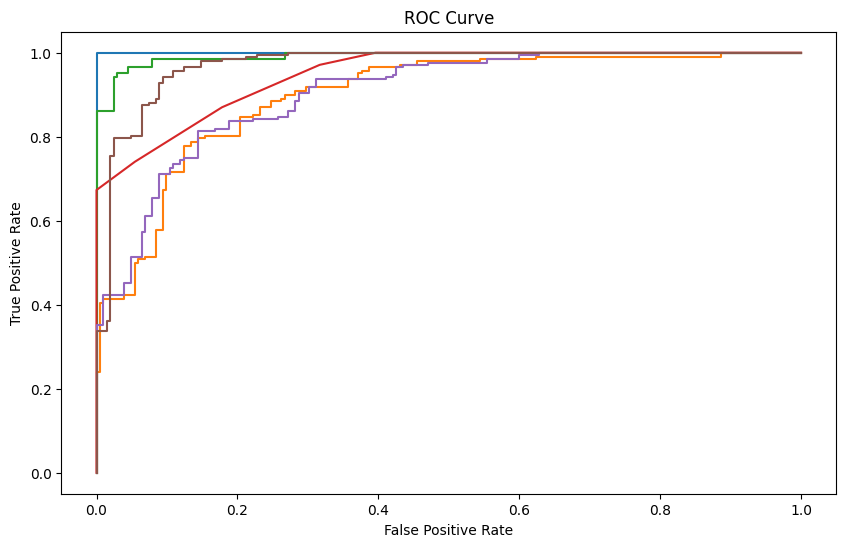

In [15]:
from sklearn.metrics import roc_auc_score, roc_curve

y_probs = [ rf.predict_proba(X_test)[:,1],
            nb.predict_proba(X_test)[:,1],
            gb.predict_proba(X_test)[:,1],
            knn.predict_proba(X_test_scaled)[:,1],
            lr.predict_proba(X_test_scaled)[:,1],
            svc.decision_function(X_test_scaled)
          ]

fpr = []
tpr = []
thresh = []

for y_prob in y_probs:
    fpr_, tpr_, thresh_ = roc_curve(y_test, y_prob)
    fpr.append(fpr_)
    tpr.append(tpr_)
    thresh.append(thresh_)

labels = ["Random FD", "Naive Bayes", "Gradient Boosting", "KNN", "Logistic Regression", "SVC"]

plt.figure(figsize=(10, 6))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')


for i in range(len(models)):
    plt.plot(fpr[i], tpr[i], label=f'{model_names[i]}: {round(roc_auc_score(y_test, y_probs[i]), 3)}')

## Hyperparameter Tuning

In [16]:
from sklearn.model_selection import GridSearchCV

param_grid = { 'n_estimators': [100, 200, 500],
               'max_depth': [None, 10, 20, 30],
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4],
               'max_features': ['sqrt', 'log2', None]
             }

rf = RandomForestClassifier( random_state = 42,
                             n_jobs       = -1
                           )

grid_search = GridSearchCV( rf,
                            param_grid, 
                            cv         = 3, 
                            verbose    = 2, 
                            n_jobs     = -1
                          )

In [17]:
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 324 candidates, totalling 972 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'max_features': ['sqrt', 'log2', None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 500]},
             verbose=2)

In [18]:
best_rf = grid_search.best_estimator_

## Feature Importances 

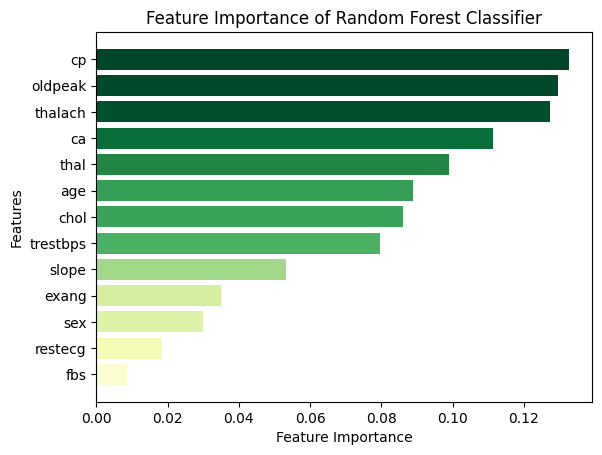

In [20]:
feature_importances = best_rf.feature_importances_
features = best_rf.feature_names_in_

sorted_idx = np.argsort(feature_importances)
sorted_features = features[sorted_idx]
sorted_importances = feature_importances[sorted_idx]

colors = plt.cm.YlGn(sorted_importances / max(sorted_importances))

plt.barh( y = sorted_features,
          width = sorted_importances,
          color = colors 
        )

plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance of Random Forest Classifier')
plt.show()

<Axes: >

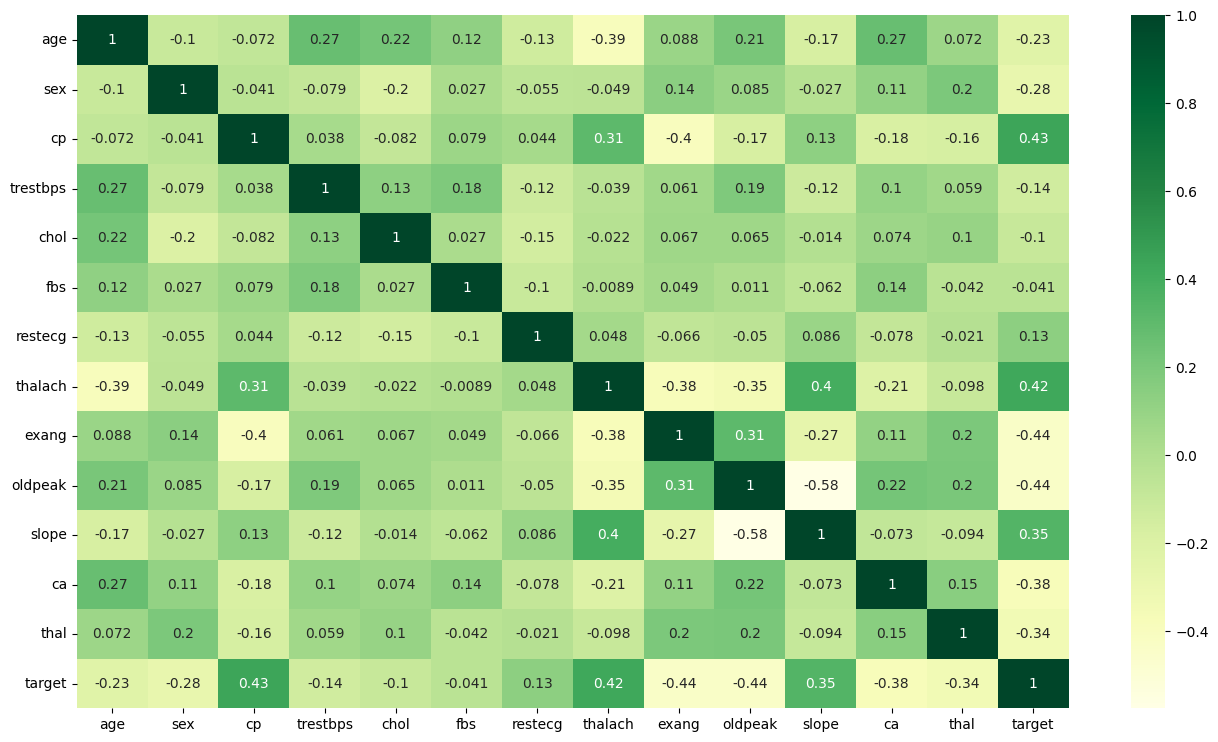

In [29]:
plt.figure(figsize=(16, 9))
sns.heatmap( df.corr(),
             annot = True,
             cmap = 'YlGn' 
           )